# **Universidad Icesi - Maestría en Ciencia de Datos**
## Parcial Práctico de Series de Tiempo
## Daniel Martinez & Felipe Montenegro

# **Sección 1 - Librerías**

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.lines as mlines
from matplotlib import rc
import matplotlib as mpl
import pandas as pd
from bayes_opt import BayesianOptimization
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# **Sección 2 - Lectura de Datos**

In [187]:
data = pd.read_csv("Examen.csv")
data


Unnamed: 0    producto1    producto2
0             1  4000.000000  3000.000000
1             2  3997.400893  3010.686220
2             3  3978.605317  3022.018584
3             4  3986.454125  3033.920990
4             5  3979.695678  3038.402098
..          ...          ...          ...
122         123  3664.610771  3429.293034
123         124  3650.881839  3437.099467
124         125  3651.788470  3453.155282
125         126  3637.047639  3472.528345
126         127  3641.990873  3476.058092

[127 rows x 3 columns]

# **Sección 3 - Análisis Descriptivo**

Teniendo en cuenta que no tenemos la variable tiempo, es necesario modificar la colmna "Unnamed" y definir la fecha de inicio de la serie.

In [188]:
# Cargar el dataset
data = pd.read_csv('Examen.csv')

data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

data['Date'] = pd.to_datetime(data['Date'], unit='D', origin='2008-01-01')

data.set_index('Date', inplace=True)
data.head()

producto1    producto2
Date                                
2008-01-02  4000.000000  3000.000000
2008-01-03  3997.400893  3010.686220
2008-01-04  3978.605317  3022.018584
2008-01-05  3986.454125  3033.920990
2008-01-06  3979.695678  3038.402098

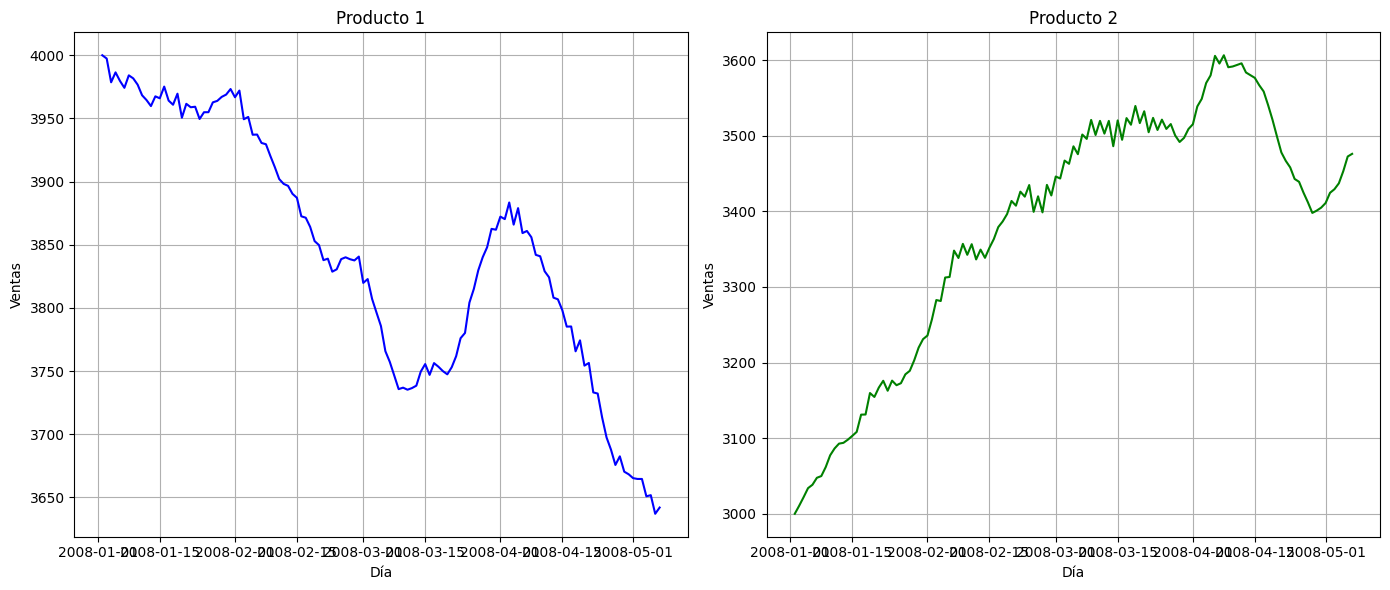

In [189]:



# Crear una figura con dos subplots (uno para cada producto)
plt.figure(figsize=(14, 6))

# Gráfico para producto 1
plt.subplot(1, 2, 1)
plt.plot(data.index, data['producto1'], color='blue')  # Eliminamos marker='o'
plt.title('Producto 1')
plt.xlabel('Día')
plt.ylabel('Ventas')
plt.grid(True)

# Gráfico para producto 2
plt.subplot(1, 2, 2)
plt.plot(data.index, data['producto2'], color='green')  # Eliminamos marker='o'
plt.title('Producto 2')
plt.xlabel('Día')
plt.ylabel('Ventas')
plt.grid(True)

# Ajustar el layout para que los subplots no se solapen
plt.tight_layout()

# Mostrar las gráficas
plt.show()


### **Componentes de las series de tiempo**

In [190]:
product_1_df = data[['producto1']]
product_1_df.index = data.index
# --------------------------------------
product_2_df = data[['producto2']]
product_2_df.index = data.index



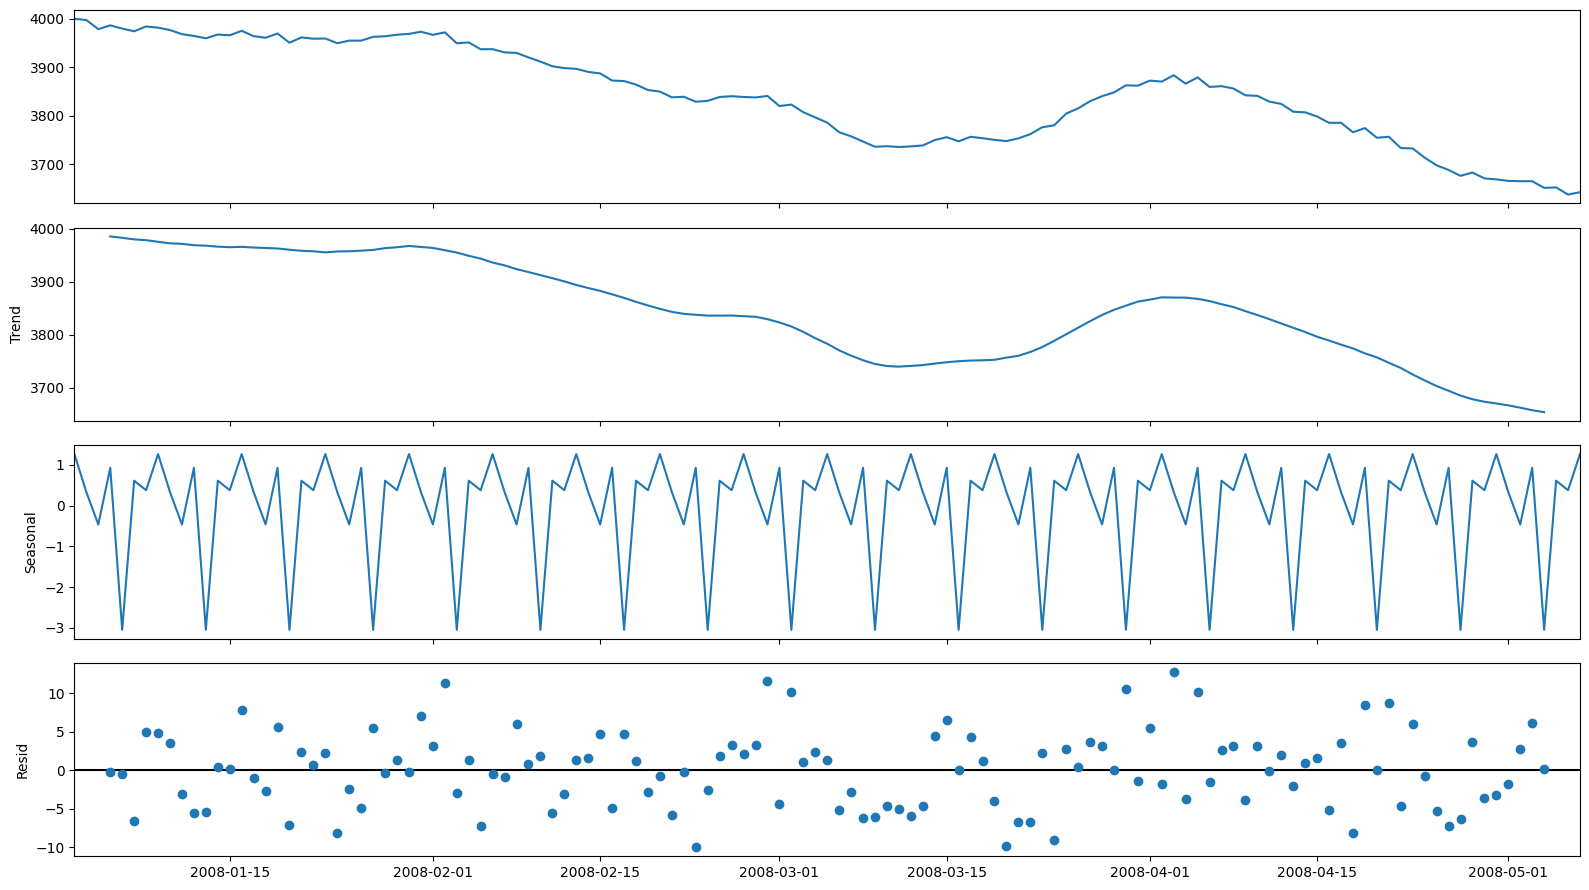

In [191]:
td_componentes = seasonal_decompose(product_1_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

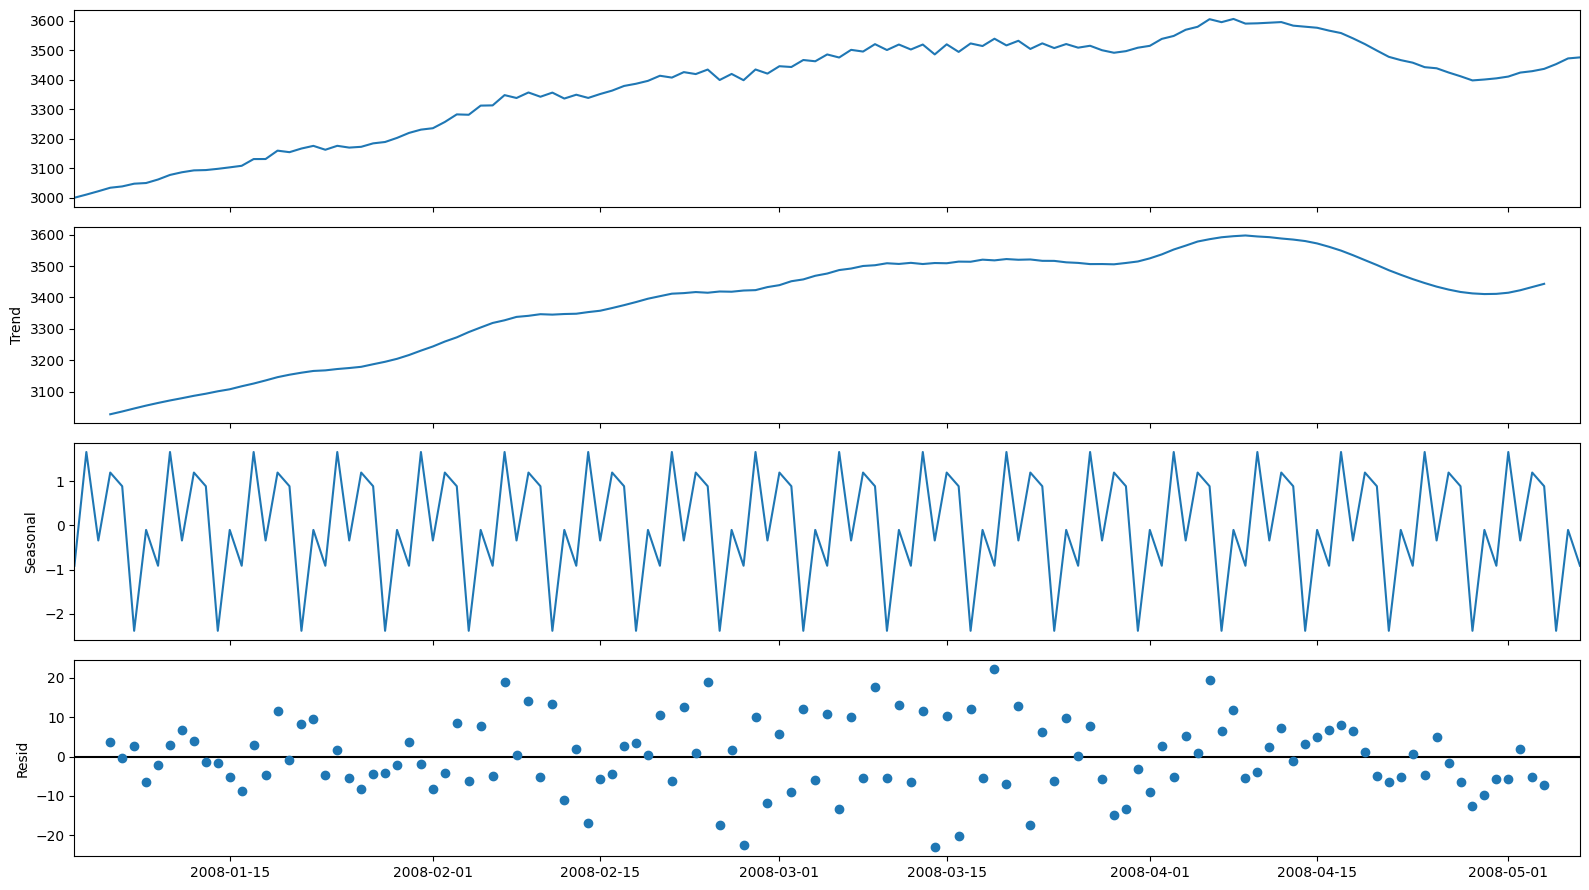

In [192]:
td_componentes = seasonal_decompose(product_2_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

# **Sección 4 - Protocólo de Evaluación**

### Configuración global
- Iteraciones: 10
- Predicción: 1

In [193]:
iterations = 10
train_size = data.shape[0] - iterations
horizon = 1

### Función Protocolo de Evaluación - Ventana Móvil

In [194]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def rolling_window_evaluation(
    model_class,
    data,
    target_column,
    initial_train_size,
    num_iterations,
    forecast_horizon=1,
    init_args=None,
    fit_args=None
):
    test_errors = []
    forecasts = []
    
    best_model = None
    lowest_error = float('inf')

    # Ensure init_args and fit_args are dictionaries
    if init_args is None:
        init_args = {}
    if fit_args is None:
        fit_args = {}

    for i in range(num_iterations):
        train_window = data.iloc[i:i + initial_train_size]
        test_window = data.iloc[i + initial_train_size:i + initial_train_size + forecast_horizon]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Instantiate the model with provided init_args
        model = model_class(y_train, **init_args)

        # Fit the model with fit_args if provided
        model_fit = model.fit(**fit_args)

        # Forecast the next point(s)
        test_predictions = model_fit.forecast(forecast_horizon)
        forecasts.append(test_predictions.iloc[0])

        # Calculate the test error
        test_error = mean_squared_error(y_test, test_predictions)
        test_errors.append(test_error)

        # Check if this model has the lowest error and store it
        if test_error < lowest_error:
            lowest_error = test_error
            best_model = model_fit

    return test_errors, forecasts, best_model


### Función para graficar los valores predichos

In [195]:
import matplotlib.pyplot as plt

def plot_forecast(data, forecasts, train_size):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    # Full plot with highlighted forecast section
    ax[0].plot(list(range(0, data.shape[0])), data, label='Actual Data', color='blue')
    forecast_indices = range(train_size, train_size + len(forecasts))
    ax[0].plot(forecast_indices, forecasts, label='Forecast', color='orange')
    ax[0].axvspan(train_size, train_size + len(forecasts), color='gray', alpha=0.3)
    ax[0].set_title('Actual Data with Forecast Overlay')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Value')
    ax[0].legend()
    ax[0].grid(True)

    # Zoomed-in section on forecast
    ax[1].plot(forecast_indices, data[train_size:train_size + len(forecasts)], label='Actual Data (Zoomed)', color='blue', marker='o')
    ax[1].plot(forecast_indices, forecasts, label='Forecast (Zoomed)', color='orange', marker='o')

    # Adding subtle lines to indicate the delta between actual and forecast
    for i in range(len(forecasts)):
        ax[1].plot([forecast_indices[i], forecast_indices[i]], [data[train_size + i], forecasts[i]], color='red', linestyle='--', linewidth=2)

    ax[1].set_title('Zoomed-In Forecast Section with Delta Lines')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Value')
    ax[1].legend()
    ax[1].grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


# **Sección 5 - Desarrollo de Modelos**

## **Despligue para Producto 1**

### 5.1 Promedio Móvil

In [196]:
import pandas as pd
import numpy as np

class MovingAverageModel:
    def __init__(self, endog, window):
        self.endog = endog
        self.window = window
        self.fittedvalues = None

    def fit(self):
        self.fittedvalues = self.endog.rolling(window=self.window).mean().dropna()
        return self

    def forecast(self, steps):
        last_window = self.endog.iloc[-self.window:]
        forecast_values = np.full(steps, last_window.mean())
        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))


moving_average_test_errors, moving_average_forecasts, moving_average_model = rolling_window_evaluation(
    model_class=MovingAverageModel,
    data=data,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args={
        'window': 3
	}
)

moving_average_rmse = np.sqrt(np.mean(moving_average_test_errors))
print(f"Promedio móvil RMSE: {moving_average_rmse}")
print(moving_average_model)


Promedio móvil RMSE: 9.680204135597737


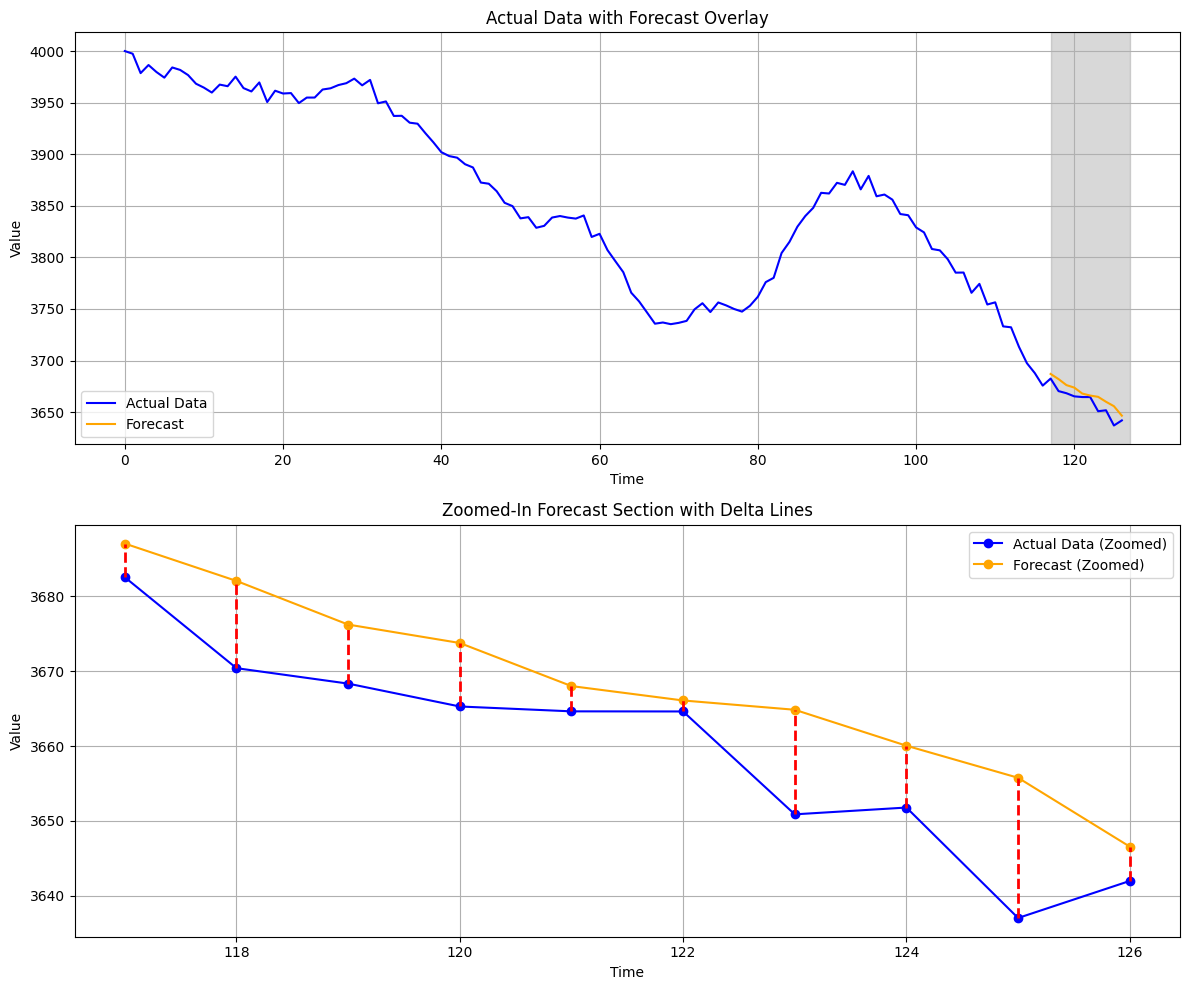

In [197]:
plot_forecast(data['producto1'], moving_average_forecasts, train_size)

## **5.2 Suavización Exponencial Holt Winters**

Con el objetivo de encontrar o más bien seleccionar los mejores hiperparámetros, llevaremos a cabo la aplicación de la técnica **Optimización Bayesiana**

In [198]:
# Buscando facilitar el uso de la técnica de optimización bayesiana procedemos a separar el dataset según el producto a utilizar:

data_producto1 = data.copy()

data_producto2 = data.copy()

#Frecuencia
data_producto1.index = pd.to_datetime(data_producto1.index)
data_producto1 = data_producto1.asfreq('D')  # Use daily frequency

data_producto2.index = pd.to_datetime(data_producto2.index)
data_producto2 = data_producto2.asfreq('D')  # Use daily frequency

print(data_producto1.head())
print(data_producto2.head())


              producto1    producto2
Date                                
2008-01-02  4000.000000  3000.000000
2008-01-03  3997.400893  3010.686220
2008-01-04  3978.605317  3022.018584
2008-01-05  3986.454125  3033.920990
2008-01-06  3979.695678  3038.402098
              producto1    producto2
Date                                
2008-01-02  4000.000000  3000.000000
2008-01-03  3997.400893  3010.686220
2008-01-04  3978.605317  3022.018584
2008-01-05  3986.454125  3033.920990
2008-01-06  3979.695678  3038.402098


In [199]:
def train_and_evaluate_RMSE_bayes(error, trend, seasonal, alpha, beta, gamma):    
    # Map the parameters (error, trend, seasonal) to actual model components
    error1 = ["add", "mul"]
    trend1 = ["add", "mul", None]
    seasonal1 = ["add", "mul", None]
    
    # Round and map parameters
    alpha = round(alpha, 2)
    beta = round(beta, 2)
    gamma = round(gamma, 2)

    init_args = {
        'error': error1[round(error)],
        'trend': trend1[round(trend)],
        'seasonal': seasonal1[round(seasonal)] if seasonal1[round(seasonal)] != "None" else None,
        'seasonal_periods': 7
    }

    fit_args = {
        'smoothing_level': alpha,
        'smoothing_trend': beta if trend1[round(trend)] else None,
        'smoothing_seasonal': gamma if seasonal1[round(seasonal)] else None
    }
    
    # Use rolling window evaluation
    test_errors, forecasts, _ = rolling_window_evaluation(
        model_class=ETSModel,
        data=data_producto1,
        target_column='producto1',
        initial_train_size=train_size,
        num_iterations=iterations,
        forecast_horizon=horizon,
        init_args=init_args,
        fit_args=fit_args
    )
    
    # Compute the average RMSE over all iterations
    avg_rmse = np.sqrt(np.mean(test_errors))

    print(f"Average RMSE: {avg_rmse}, Error: {error1[round(error)]}, Trend: {trend1[round(trend)]}, Seasonal: {seasonal1[round(seasonal)]}, Alpha: {alpha}, Beta: {beta}, Gamma: {gamma}")

    # Return the negative RMSE for Bayesian Optimization (since it maximizes)
    return -avg_rmse


In [200]:
import warnings
warnings.filterwarnings("ignore")

pbounds = {
    'error':  (0, 1),
    'trend': (0, 2),
    'seasonal': (0, 2),
    'alpha': (0.01, 0.99),
    'beta': (0.01, 0.99),
    'gamma': (0.01, 0.99)
}

optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE_bayes,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

optimizer.maximize(
    init_points=10,
    n_iter=50
)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.18447D+00    |proj g|=  8.99900D-01

At iterate    1    f=  3.63645D+00    |proj g|=  2.05626D-01

At iterate    2    f=  3.62645D+00    |proj g|=  1.50756D-01

At iterate    3    f=  3.61723D+00    |proj g|=  1.52883D-01

At iterate    4    f=  3.61378D+00    |proj g|=  4.95323D-02

At iterate    5    f=  3.59899D+00    |proj g|=  8.66321D-02

At iterate    6    f=  3.58706D+00    |proj g|=  8.07664D-02

At iterate    7    f=  3.58685D+00    |proj g|=  1.37916D-01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    8    f=  3.58243D+00    |proj g|=  1.10624D-01

At ite


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   68    f=  3.43423D+00    |proj g|=  7.41164D-01

At iterate   69    f=  3.43124D+00    |proj g|=  3.48341D-01

At iterate   70    f=  3.43061D+00    |proj g|=  1.27192D-01

At iterate   71    f=  3.43060D+00    |proj g|=  2.19386D-02

At iterate   72    f=  3.43060D+00    |proj g|=  1.58476D-02

At iterate   73    f=  3.43060D+00    |proj g|=  8.92650D-03

At iterate   74    f=  3.43059D+00    |proj g|=  3.24901D-02

At iterate   75    f=  3.43057D+00    |proj g|=  9.91047D-02

At iterate   76    f=  3.43052D+00    |proj g|=  2.07669D-01

At iterate   77    f=  3.43039D+00    |proj g|=  4.93975D-02

At iterate   78    f=  3.43029D+00    |proj g|=  9.07957D-01

At iterate   79    f=  3.42999D+00    |proj g|=  7.70364D-01

At iterate   80    f=  3.42810D+00    |proj g|=  2.42794D-01

At iterate   81    f=  3.42594D+00    |proj g|=  1.62687D-01

At iterate   82    f=  3.42529D+00    |proj g|=  1.00254D+00

At iterate   83    f=  3.42268D+00    |proj g|=  8.62804D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21061D+00    |proj g|=  6.50654D+00

At iterate    1    f=  5.20971D+00    |proj g|=  8.99871D-01

At iterate    2    f=  5.17339D+00    |proj g|=  1.37834D+01

At iterate    3    f=  4.89506D+00    |proj g|=  5.74476D+01

At iterate    4    f=  4.61217D+00    |proj g|=  6.44012D+01

At iterate    5    f=  4.19827D+00    |proj g|=  5.82343D+01

At iterate    6    f=  3.82263D+00    |proj g|=  4.21581D+01

At iterate    7    f=  3.62946D+00    |proj g|=  2.26428D+01

At iterate    8    f=  3.60651D+00    |proj g|=  1.49705D+01

At iterate    9    f=  3.59924D+00    |proj g|=  1.10582D+01

At iterate   10    f=  3.58839D+00    |proj g|=  2.65926D+00

At iterate   11    f=  3.58615D+00    |proj g|=  8.04929D-01

At iterate   12    f=  3.58578D+00    |proj g|=  5.51001D-01

At iterate   13    f=  3.58284D+00    |proj g|=  8.44533D-01

At iterate   14    f=  3.58187D+00    |proj g|=  1.01250D+01

At iterate   15  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12395D+00    |proj g|=  1.12945D+00

At iterate    1    f=  5.11604D+00    |proj g|=  1.51091D+00

At iterate    2    f=  5.00346D+00    |proj g|=  1.42909D+00

At iterate    3    f=  4.79796D+00    |proj g|=  1.34980D+01

At iterate    4    f=  4.33662D+00    |proj g|=  1.06766D+01

At iterate    5    f=  4.27191D+00    |proj g|=  3.77751D+01

At iterate    6    f=  3.93052D+00    |proj g|=  2.39603D+01

At iterate    7    f=  3.85496D+00    |proj g|=  6.94481D+00

At iterate    8    f=  3.80728D+00    |proj g|=  5.09158D+01

At iterate    9    f=  3.74457D+00    |proj g|=  3.28795D+01

At iterate   10    f=  3.71409D+00    |proj g|=  1.66777D+01

At iterate   11    f=  3.70555D+00    |proj g|=  1.41434D+01

At iterate   12    f=  3.69948D+00    |proj g|=  2.03598D+00

At iterate   13    f=  3.6

In [201]:
optimizer.max

{'target': -7.150008625565331,
 'params': {'alpha': 0.99,
  'beta': 0.99,
  'error': 1.0,
  'gamma': 0.01,
  'seasonal': 0.0,
  'trend': 1.7416685551133473}}

In [202]:
values_map = {0: None, 1: "add", 2: "mul"}

data_copy = data.copy()
data_copy = data_copy.asfreq('D')

init_args = {
    'error': values_map[round(optimizer.max['params']['error'])],
    'trend': values_map[round(optimizer.max['params']['trend'])],
    'seasonal': values_map[round(optimizer.max['params']['seasonal'])],
}

fit_args = {
    'smoothing_level': optimizer.max['params']['alpha'],
    'smoothing_trend': optimizer.max['params']['beta'] if init_args['trend'] else None,
    'smoothing_seasonal': optimizer.max['params']['gamma'] if init_args['seasonal'] else None
}

filtered_init = {k: v for k, v in init_args.items() if v is not None}
filtered_fit = {k: v for k, v in fit_args.items() if v is not None}

test_errors, forecasts, best_model = rolling_window_evaluation(
    model_class=ETSModel,
    data=data_copy,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args=filtered_init,
    fit_args=filtered_fit
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19435D+00    |proj g|=  1.91011D+01

At iterate    1    f=  5.19068D+00    |proj g|=  1.13353D+01

At iterate    2    f=  5.18778D+00    |proj g|=  8.99689D-01

At iterate    3    f=  5.18593D+00    |proj g|=  3.60690D+00

At iterate    4    f=  5.17414D+00    |proj g|=  1.85432D+01

At iterate    5    f=  5.14876D+00    |proj g|=  3.61187D+01

At iterate    6    f=  5.07550D+00    |proj g|=  6.06786D+01

At iterate    7    f=  4.94659D+00    |proj g|=  7.63741D+01

At iterate    8    f=  4.80251D+00    |proj g|=  7.79110D+01

At iterate    9    f=  4.42043D+00    |proj g|=  6.83327D+01

At iterate   10    f=  3.90979D+00    |proj g|=  5.07244D+01

At iterate   11    f=  3.61932D+00    |proj g|=  2.82476D+01

At iterate   12    f=  3.55479D+00    |proj g|=  1.47204D+01

At iterate   13    f=  3.5

In [203]:
print(f'Best Model: {best_model}')
print(f'Test Errors: {test_errors}')
print(f'Forecasts: {forecasts}')
# rmse
holt_winters_rmse = np.sqrt(np.mean(test_errors))
print(f'RMSE: {holt_winters_rmse}')

Best Model: <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper object at 0x31acaa760>
Test Errors: [430.19022516680224, 0.3429374214039957, 0.4864925620293646, 1.663606866632874, 2.4175154438864794, 7.4364629702730864, 139.3455170552126, 3.2912021936560056, 66.37229805886844, 115.83368241386383]
Forecasts: [3661.7852288944305, 3670.9756098381567, 3669.025915285056, 3666.5644083916236, 3663.0706355458424, 3661.8837832323975, 3662.6863095400117, 3649.9743025605376, 3645.194558956911, 3631.2282669273222]
RMSE: 8.760022489426776


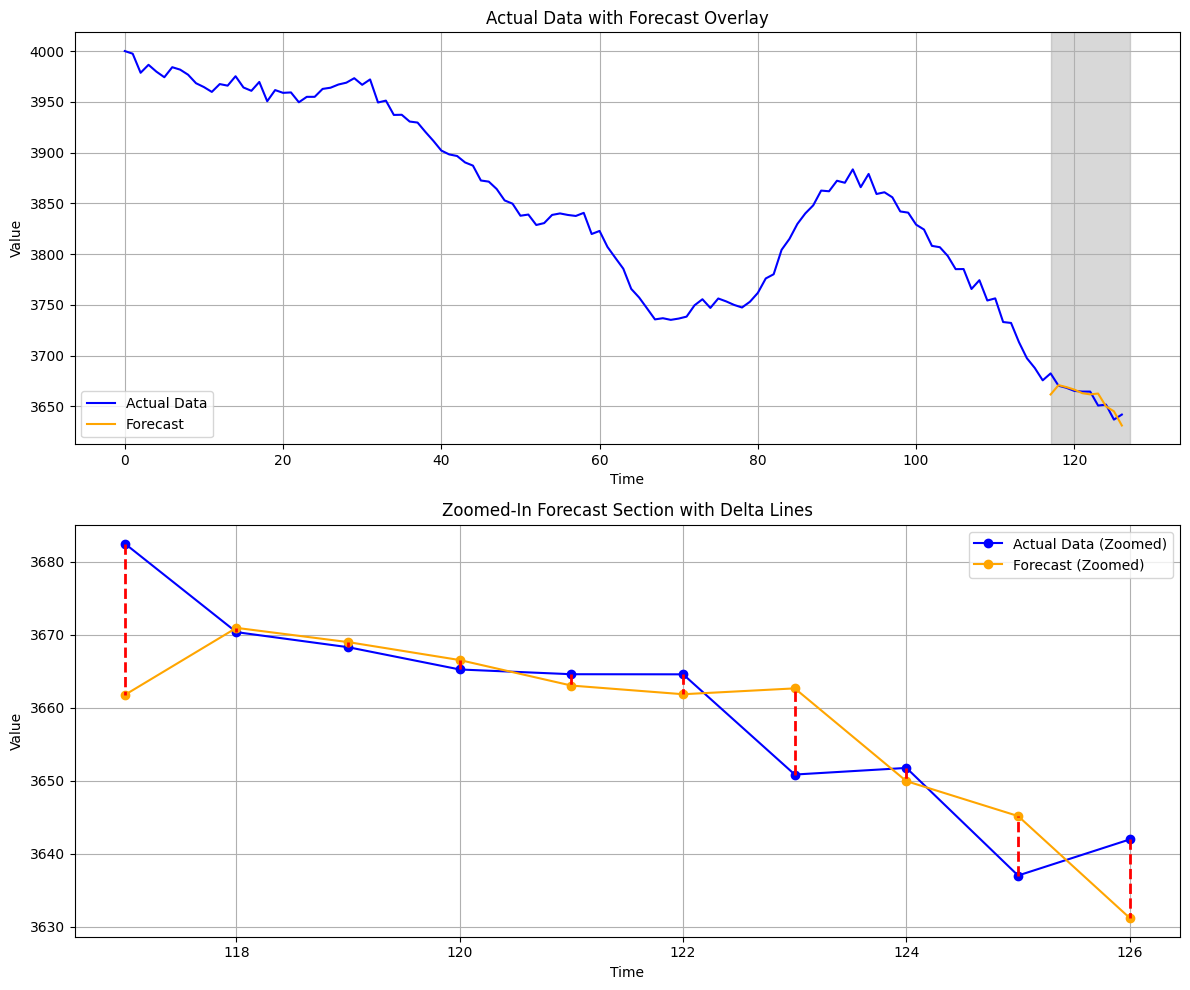

In [204]:
plot_forecast(data['producto1'], forecasts, train_size)

## **5.3 Modelos de Regresión (Tendencia y Estacionalidad)**

In [205]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

class PolynomialRegressionSeasonalModel:
    def __init__(self, endog, degree, seasonal_periods):
        self.endog = endog
        self.degree = degree  # Degree of the polynomial
        self.seasonal_periods = seasonal_periods  # Number of seasonal periods
        self.model = None  # This will store the LinearRegression model
        self.poly = PolynomialFeatures(degree=self.degree)
        self.fittedvalues = None	
        self.seasonal_dummies = pd.get_dummies(np.arange(self.seasonal_periods) % self.seasonal_periods, drop_first=False)

    def _create_design_matrix(self, y_train, future_steps=None):
        if future_steps is None:
            time_index = np.arange(len(y_train)).reshape(-1, 1)
            seasonality = pd.get_dummies(np.arange(len(y_train)) % self.seasonal_periods, drop_first=False)
        else:
            time_index = np.arange(len(self.endog), len(self.endog) + future_steps).reshape(-1, 1)
            seasonality = pd.get_dummies(np.arange(len(self.endog), len(self.endog) + future_steps) % self.seasonal_periods, drop_first=False)

        poly_features = self.poly.fit_transform(time_index)

        seasonality = seasonality.reindex(columns=self.seasonal_dummies.columns, fill_value=0)

        X = np.hstack([poly_features, seasonality])

        return X

    def fit(self):
        # Create the design matrix for the training data
        X_train = self._create_design_matrix(self.endog)

        # Fit the polynomial regression model
        self.model = LinearRegression().fit(X_train, self.endog)
        
        # Store the fitted values
        self.fittedvalues = pd.Series(self.model.predict(X_train), index=self.endog.index)

        return self

    def forecast(self, steps):
        # Create the design matrix for the future steps
        X_future = self._create_design_matrix(self.endog, future_steps=steps)

        # Forecast the next steps
        forecast_values = self.model.predict(X_future)

        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))

In [206]:
best_polynomial_forecasts = []
rmses = []
forecasts = []
polynomial_RMSE = None

for i in range(1, 20):
	print(f"Polynomial of degree {i}")
	polynomial_test_errors, polynomial_forecasts, polynomial_model = rolling_window_evaluation(
		model_class=PolynomialRegressionSeasonalModel,
		data=data,
		target_column='producto1',
		initial_train_size=train_size,
		num_iterations=iterations,
		forecast_horizon=horizon,
		init_args={
			'degree': i,
			'seasonal_periods': 7
		}
	)
	polynomial_rmse = np.sqrt(np.mean(polynomial_test_errors))
	polynomial_RMSE = polynomial_rmse if polynomial_RMSE is None else min(polynomial_RMSE, polynomial_rmse)
	forecasts.append(polynomial_forecasts)
	if polynomial_rmse == polynomial_RMSE:
		best_polynomial_forecasts = polynomial_forecasts
	print(f"Polynomial RMSE: {polynomial_rmse}")
	rmses.append(polynomial_rmse)

Polynomial of degree 1
Polynomial RMSE: 55.675678561198104
Polynomial of degree 2
Polynomial RMSE: 84.5918080464048
Polynomial of degree 3
Polynomial RMSE: 64.42115058087214
Polynomial of degree 4
Polynomial RMSE: 67.11019305443017
Polynomial of degree 5
Polynomial RMSE: 96.68212825816893
Polynomial of degree 6
Polynomial RMSE: 34.0527422324109
Polynomial of degree 7
Polynomial RMSE: 43.843289851296646
Polynomial of degree 8
Polynomial RMSE: 40.24397433432629
Polynomial of degree 9
Polynomial RMSE: 18.1476799440538
Polynomial of degree 10
Polynomial RMSE: 16.047194274125033
Polynomial of degree 11
Polynomial RMSE: 12.584842300411939
Polynomial of degree 12
Polynomial RMSE: 14.231719492712685
Polynomial of degree 13
Polynomial RMSE: 24.19275431778403
Polynomial of degree 14
Polynomial RMSE: 56.21960309859819
Polynomial of degree 15
Polynomial RMSE: 101.64735951711397
Polynomial of degree 16
Polynomial RMSE: 153.34132684793005
Polynomial of degree 17
Polynomial RMSE: 204.83689671740373
P

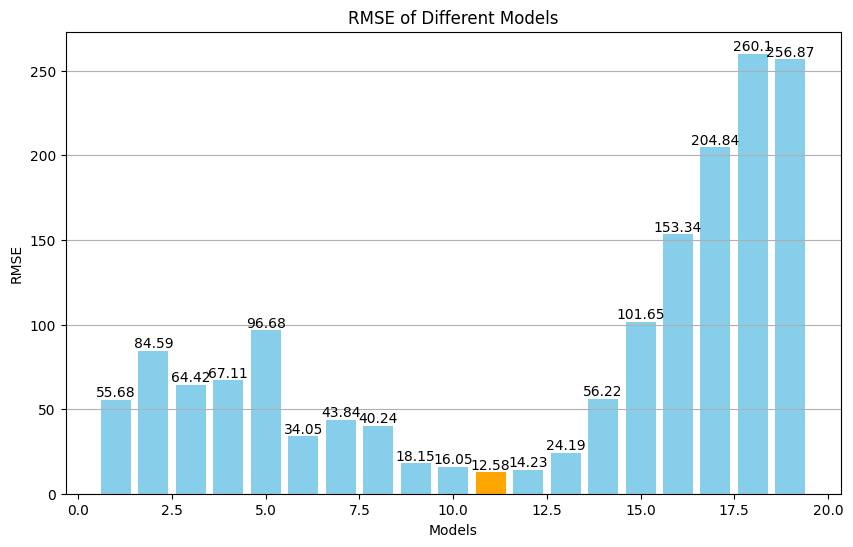

In [207]:
# Identify the index of the lowest RMSE value
min_index = rmses.index(min(rmses))

# Define colors for the bars
colors = ['skyblue' if i != min_index else 'orange' for i in range(len(rmses))]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, len(rmses) + 1), rmses, color=colors)

# Add numbers below each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE of Different Models')
plt.grid(axis='y')

# Display the chart
plt.show()

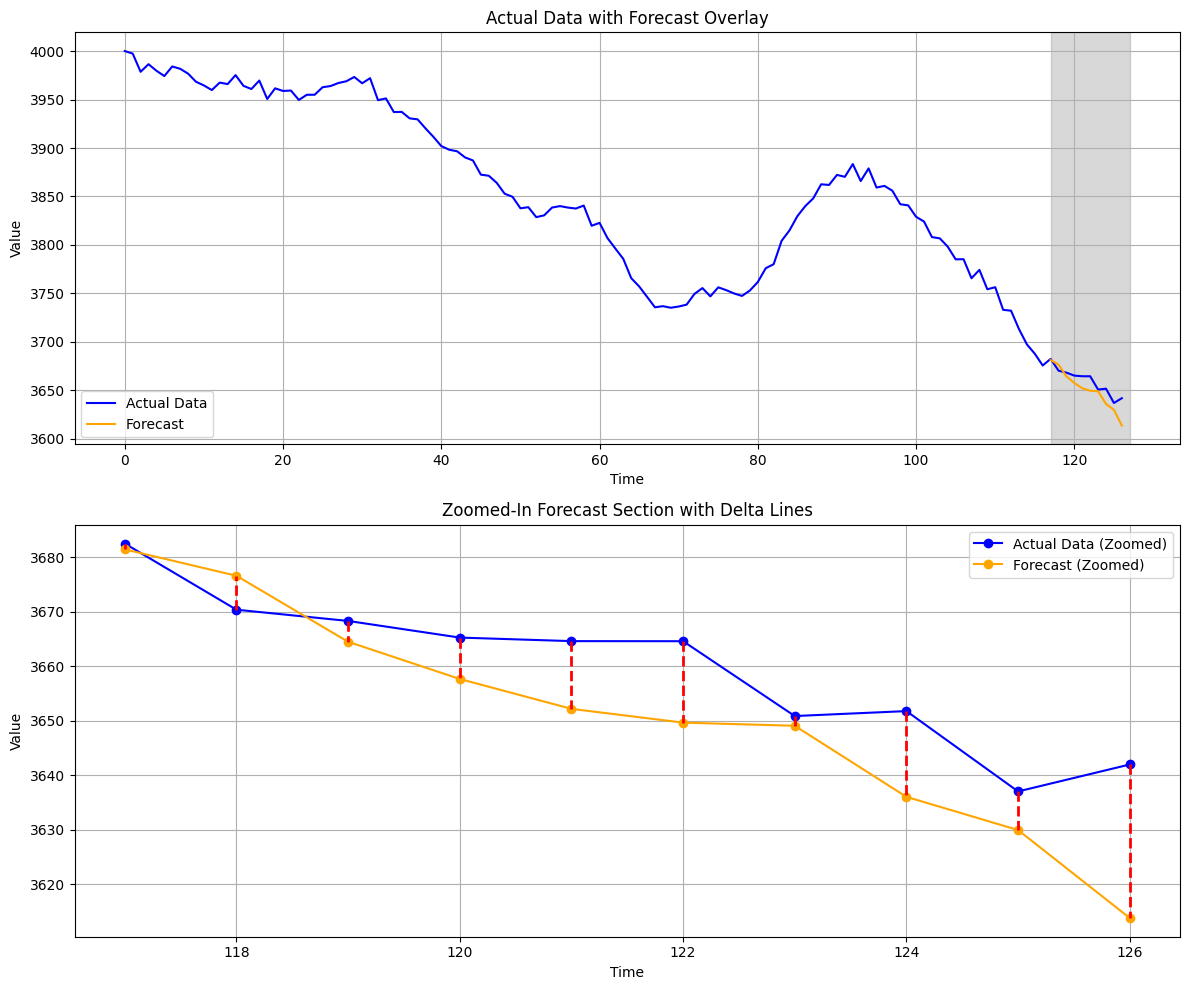

In [208]:
plot_forecast(data['producto1'], best_polynomial_forecasts, train_size)

### Modelos ARIMA - Versión Felipe


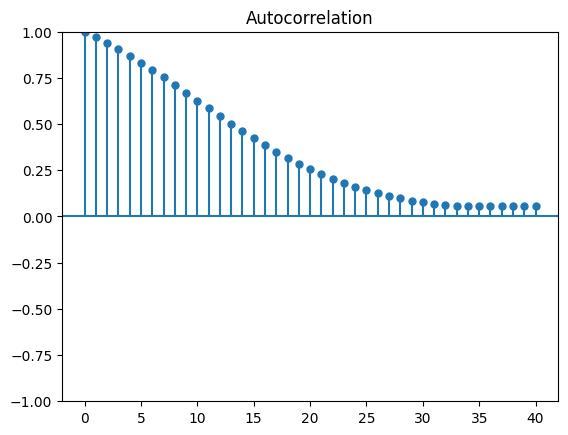

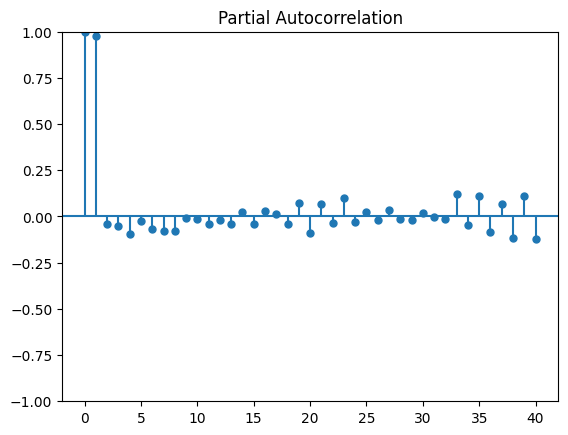

In [209]:
#Gráficas de ACF y PACF

from pmdarima import plot_acf, plot_pacf

plot_acf(data['producto1'],lags=40);
plot_pacf(data['producto1'],lags=40);

In [210]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def rolling_window_evaluation_arima(
    data, 
    target_column, 
    initial_train_size, 
    num_iterations, 
    forecast_horizon=1, 
    order=(1, 1, 1)
):
    """
    Protocolo de evaluación con ventanas deslizantes (rolling window) para modelos ARIMA.
    """
    test_errors = []
    forecasts = []

    for i in range(num_iterations):
        # Definir ventanas de entrenamiento y prueba
        train_window = data.iloc[i:i + initial_train_size]
        test_window = data.iloc[i + initial_train_size:i + initial_train_size + forecast_horizon]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Ajustar el modelo ARIMA con el orden especificado
        model = ARIMA(y_train, order=order)
        model_fit = model.fit()

        # Pronosticar el siguiente punto(s)
        test_predictions = model_fit.forecast(forecast_horizon)
        forecasts.append(test_predictions.iloc[0])

        # Calcular el error de prueba (RMSE)
        test_error = mean_squared_error(y_test, test_predictions, squared=False)  # RMSE
        test_errors.append(test_error)

    # Calcular el RMSE promedio
    average_rmse = np.mean(test_errors)
    
    return average_rmse


# Configuración del protocolo de evaluación
iterations = 10
train_size = data.shape[0] - iterations
horizon = 1

# Lista de órdenes ARIMA (p, d, q) a probar
lista_ordenes_probar = [
    (1, 1, 1), (1, 1, 2), (1, 1, 3),
    (1, 2, 1), (1, 2, 2), (1, 2, 3),
    (1, 3, 1), (1, 3, 2), (1, 3, 3),
    (2, 1, 1), (2, 1, 2), (2, 1, 3),
    (2, 2, 1), (2, 2, 2), (2, 2, 3),
    (2, 3, 1), (2, 3, 2), (2, 3, 3),
    (3, 1, 1), (3, 1, 2), (3, 1, 3),
    (3, 2, 2), (3, 2, 3),
    (3, 3, 1), (3, 3, 2), (3, 3, 3)
]

# Evaluar cada combinación de órdenes ARIMA
rmse_results = {}
for order in lista_ordenes_probar:
    average_rmse = rolling_window_evaluation_arima(
        data=data,
        target_column='producto1',
        initial_train_size=train_size,
        num_iterations=iterations,
        forecast_horizon=horizon,
        order=order
    )
    rmse_results[order] = average_rmse
    print(f"ARIMA{order} - RMSE promedio: {average_rmse:.4f}")




ARIMA(1, 1, 1) - RMSE promedio: 7.3100
ARIMA(1, 1, 2) - RMSE promedio: 8.0031
ARIMA(1, 1, 3) - RMSE promedio: 7.0794
ARIMA(1, 2, 1) - RMSE promedio: 5.9091
ARIMA(1, 2, 2) - RMSE promedio: 6.1029
ARIMA(1, 2, 3) - RMSE promedio: 6.2812
ARIMA(1, 3, 1) - RMSE promedio: 6.4864
ARIMA(1, 3, 2) - RMSE promedio: 5.9432
ARIMA(1, 3, 3) - RMSE promedio: 6.1425
ARIMA(2, 1, 1) - RMSE promedio: 5.3871
ARIMA(2, 1, 2) - RMSE promedio: 6.0968
ARIMA(2, 1, 3) - RMSE promedio: 6.1244
ARIMA(2, 2, 1) - RMSE promedio: 5.8204
ARIMA(2, 2, 2) - RMSE promedio: 6.0928
ARIMA(2, 2, 3) - RMSE promedio: 6.1000
ARIMA(2, 3, 1) - RMSE promedio: 5.9205
ARIMA(2, 3, 2) - RMSE promedio: 5.8306
ARIMA(2, 3, 3) - RMSE promedio: 5.8701
ARIMA(3, 1, 1) - RMSE promedio: 5.4141
ARIMA(3, 1, 2) - RMSE promedio: 5.6578
ARIMA(3, 1, 3) - RMSE promedio: 6.1663
ARIMA(3, 2, 2) - RMSE promedio: 5.9945
ARIMA(3, 2, 3) - RMSE promedio: 5.8476
ARIMA(3, 3, 1) - RMSE promedio: 5.8716
ARIMA(3, 3, 2) - RMSE promedio: 5.9286
ARIMA(3, 3, 3) - RMSE pro

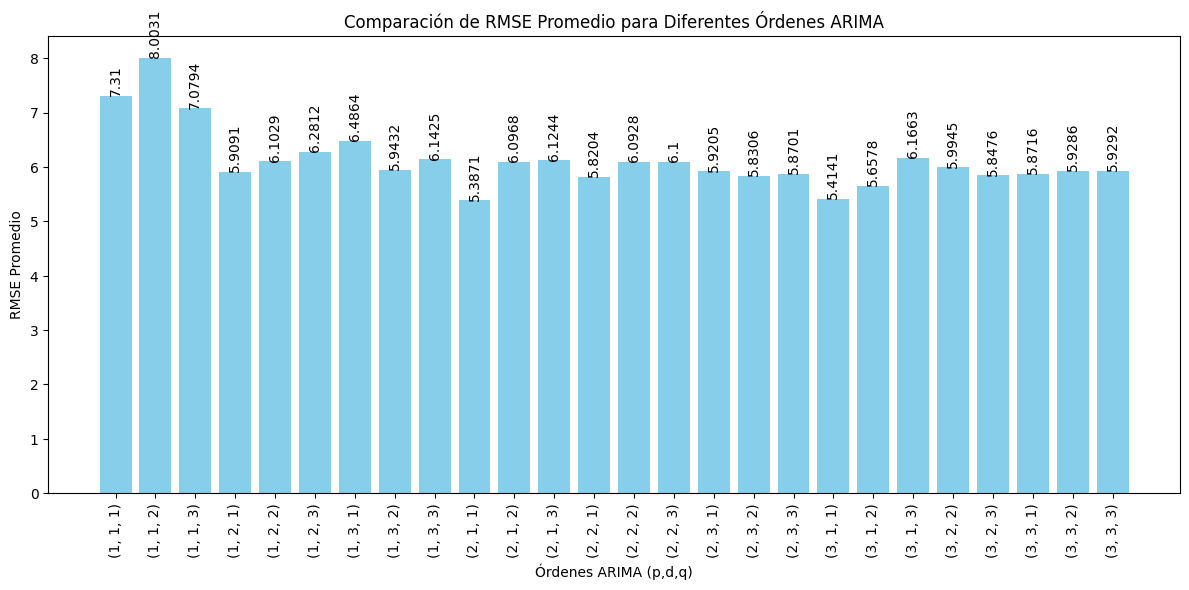

In [211]:
import matplotlib.pyplot as plt

# Gráfico de barras con etiquetas de los valores
ordenes = [str(order) for order in rmse_results.keys()]
ARIMA_rmse_values = list(rmse_results.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(ordenes, ARIMA_rmse_values, color='skyblue')

# Agregar etiquetas a cada barra con el valor del RMSE de forma vertical
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        yval, 
        round(yval, 4), 
        ha='center', 
        va='bottom', 
        fontsize=10,
        rotation=90  # Rotación vertical
    )

plt.xticks(rotation=90)
plt.xlabel('Órdenes ARIMA (p,d,q)')
plt.ylabel('RMSE Promedio')
plt.title('Comparación de RMSE Promedio para Diferentes Órdenes ARIMA')
plt.tight_layout()
plt.show()


## Tabla de RMSE aqui 

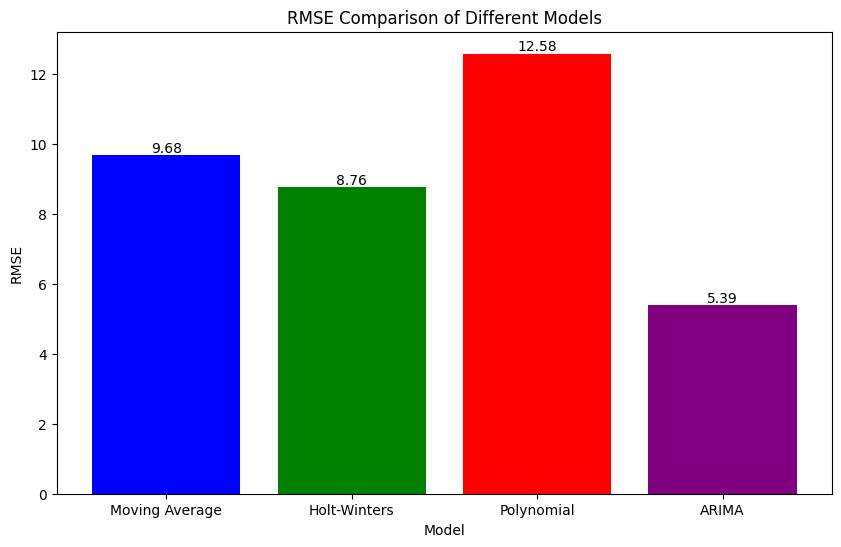

In [225]:
import matplotlib.pyplot as plt

# RMSE values and their labels
rmse_dict = {
    'Moving Average': moving_average_rmse,
    'Holt-Winters': holt_winters_rmse,
    'Polynomial': polynomial_RMSE,
    'ARIMA': min(ARIMA_rmse_values)
}

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(rmse_dict.keys(), rmse_dict.values(), color=['blue', 'green', 'red', 'purple'])

# Add values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Different Models')
plt.show()

# Mejor modelo para producto 1: ARIMA (2, 1, 1)

In [214]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


In [215]:
def apply_best_arima_model_with_residuals(data, target_column, order):
    # Fit the ARIMA model with all data
    model = ARIMA(data[target_column], order=order)
    model_fit = model.fit()

    # Forecast the next point (the 128th value)
    forecast = model_fit.forecast(steps=1)  # Forecasting one step ahead

    # Extract residuals from the fitted model
    residuals = model_fit.resid.iloc[1:]

    return forecast, residuals, model_fit

In [216]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_arch

def check_residual_normality(residuals):
    print(residuals)
    residuals = residuals.to_numpy()
    mu, std = stats.norm.fit(residuals)

    # Crear subgráficas
    plt.figure(figsize=(12, 6))

    # Histograma de los residuos con ajuste de línea normal
    plt.subplot(121)
    plt.hist(residuals, bins=25, edgecolor='k',
            density=True, alpha=0.6, color='g')
    xmin, xmax = plt.xlim()  # Limites del histograma
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title("Histograma de los Residuos")
    plt.xlabel("Residuos")
    plt.ylabel("Densidad")

    # Gráfico Q-Q
    plt.subplot(122)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Gráfico Q-Q")

    # Mostrar gráficos
    plt.tight_layout()
    plt.show()

    stat, shapiro_p = shapiro(residuals)
    
    
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    
    # Extraer el valor p de la prueba
    p_value_autocorrelation = lb_test['lb_pvalue'].iloc[0]
    
    # Prueba de ARCH para heterocedasticidad
    arch_test = het_arch(residuals)
    
    # Extraer el estadístico de prueba y el valor p
    arch_statistic = arch_test[0]
    arch_p_value = arch_test[1]
    
    fig = plt.figure(figsize=(12, 5))
    plt.plot(residuals,label="Residuales del Modelo")
    plt.title("Residuales del Modelo")
    plt.axhline(y=0, color='red', linestyle='--')
    plt.show()
    
    return {
		"shapiro": shapiro_p,
		"lb_test": p_value_autocorrelation,
		"arch_test": arch_p_value
	}

In [217]:
# Example usage
best_order = (2, 1, 1)  # The best ARIMA order you found
predicted_value, residuals, model_fit = apply_best_arima_model_with_residuals(data, 'producto1', best_order)

In [218]:
print(f"The predicted 128th value for 'producto1' is: {predicted_value.iloc[0]:.4f}")

The predicted 128th value for 'producto1' is: 3631.9742


Date
2008-01-03    -2.620540
2008-01-04   -18.902166
2008-01-05     9.845724
2008-01-06     6.558312
2008-01-07    -7.097987
                ...    
2008-05-03     2.792146
2008-05-04   -12.446452
2008-05-05    -0.283099
2008-05-06    -6.308461
2008-05-07     5.275856
Length: 126, dtype: float64


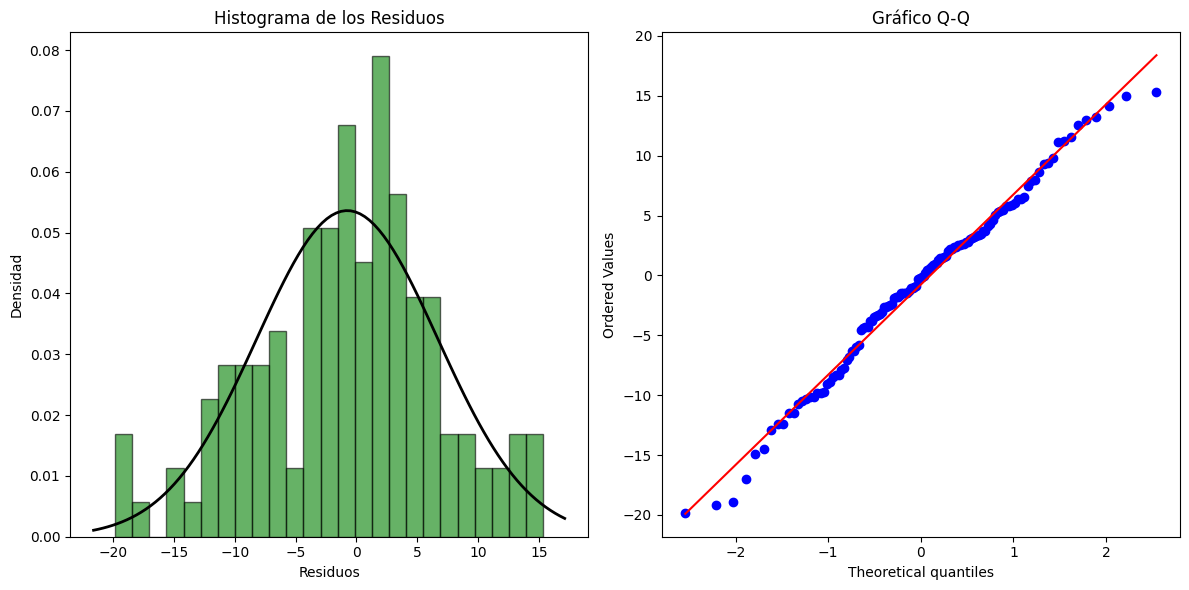

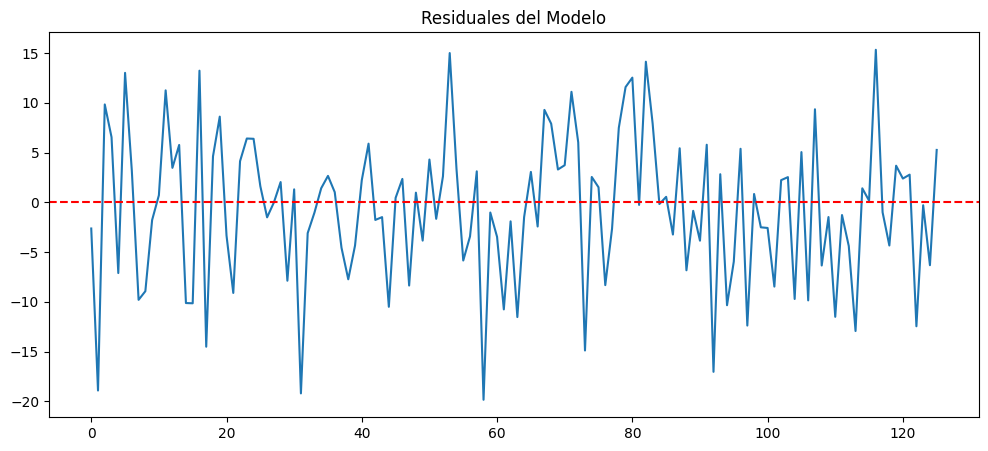

In [219]:
tests_summary = check_residual_normality(residuals)

In [220]:
tests_summary

{'shapiro': 0.29892468452453613,
 'lb_test': 0.4321401158419316,
 'arch_test': 0.1568580877130344}

## Prueba Shapiro - Wilk

### Hipótesis de la Prueba de Shapiro-Wilk

- Hipótesis Nula (H0): Los datos provienen de una distribución normal. En otras palabras, los residuos siguen una distribución normal.
- Hipótesis Alternativa (H1): Los datos no provienen de una distribución normal. Es decir, los residuos no siguen una distribución normal.


In [221]:
if tests_summary['shapiro'] > 0.05:
	print("No se rechaza la hipótesis nula: Los residuos parecen seguir una distribución normal.")
else:
	print(
		"Se rechaza la hipótesis nula: Los residuos no siguen una distribución normal.")

No se rechaza la hipótesis nula: Los residuos parecen seguir una distribución normal.


## Prueba Ljung-Box
### Hipótesis de la Prueba

- Hipótesis Nula (H0): Los residuos están autocorrelacionados (no hay autocorrelación significativa). Esto implica que los residuos son independientes y no muestran patrones de autocorrelación en los rezagos especificados.
- Hipótesis Alternativa (H1): Los residuos están autocorrelacionados (hay autocorrelación significativa). Esto sugiere que los residuos no son completamente aleatorios y podrían seguir algún patrón en los rezagos especificados.


In [222]:
if tests_summary['lb_test'] > 0.05:
	print("No se rechaza la hipótesis nula: No hay evidencia suficiente de autocorrelación en los residuos.")
else:
	print("Se rechaza la hipótesis nula: Hay evidencia de autocorrelación en los residuos.")

No se rechaza la hipótesis nula: No hay evidencia suficiente de autocorrelación en los residuos.


## Prueba ARCH
### Hipótesis de la Prueba

- Hipótesis Nula (H0): Los residuos no presentan heterocedasticidad condicional. En otras palabras, la varianza de los residuos es constante a lo largo del tiempo (es decir, la serie no sigue un modelo ARCH).
- Hipótesis Alternativa (H1): Los residuos presentan heterocedasticidad condicional. Es decir, la varianza de los residuos varía a lo largo del tiempo (es decir, la serie sigue un modelo ARCH).


In [223]:
if tests_summary['arch_test'] > 0.05:
	print("No se rechaza la hipótesis nula: Los residuos no presentan heterocedasticidad.")
else:
	print("Se rechaza la hipótesis nula: Los residuos presentan heterocedasticidad.")

No se rechaza la hipótesis nula: Los residuos no presentan heterocedasticidad.
